## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [118]:
# Input info
sample_names <- "Flt3l,Ctrl"
cells_meta_f <- "/data/isshamie/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/cells_meta.fixID.tsv"

# Saving
indir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/mergedSamples" #"/data2/mito_lineage/Analysis/annotation/output/data/"
outdir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/mergedSamples/lineages/" 

# Parameters
nTop = 25000
assay="RNA"

cores = 36

In [11]:
#samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

sample_names


[1] "Flt3l" "Ctrl"

In [3]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
plan()
plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [4]:
integrated <- readRDS(file.path(indir, paste0("allSamples.integrated.rds")))

In [5]:
integrated

An object of class Seurat 
169561 features across 18884 samples within 2 assays 
Active assay: RNA (20010 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

## Plot cells_meta

In [33]:
cells_meta <- as.data.frame(readr::read_tsv(cells_meta_f)) # %>% tidyr::unite(barcode)
cells_meta

Rows: 14857 Columns: 9

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): ID, raw ID, condition
dbl (6): index, new index, donor, donor_index, lineage, lineage_index


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



index,ID,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
3978,Ctrl_GGTTGCGAGGTCGTTT-1,GGTTGCGAGGTCGTTT-1,3979,Control,0,1036,0,1
12985,Flt3l_GGCACGTAGATCTAAG-1,GGCACGTAGATCTAAG-1,12986,Flt3l,0,3185,0,2
15690,Flt3l_TGACTCCGTTCCCAAA-1,TGACTCCGTTCCCAAA-1,15691,Flt3l,0,3808,0,3
1011,Ctrl_AGGCCCAAGTTAGAGT-1,AGGCCCAAGTTAGAGT-1,1012,Control,0,277,1,1
4867,Ctrl_TCAAGCAGTGAGTCGA-1,TCAAGCAGTGAGTCGA-1,4868,Control,0,1275,1,2
11747,Flt3l_GAGTGAGTCAGCACTA-1,GAGTGAGTCAGCACTA-1,11748,Flt3l,0,2892,1,3
12089,Flt3l_GCATGATCACCTATTT-1,GCATGATCACCTATTT-1,12090,Flt3l,0,2973,1,4
14376,Flt3l_TACCTATCAGAACAGC-1,TACCTATCAGAACAGC-1,14377,Flt3l,0,3507,1,5
23,Ctrl_AAACTCGGTATCCTTT-1,AAACTCGGTATCCTTT-1,24,Control,0,8,2,1


In [34]:
rownames(cells_meta) = cells_meta$ID

integrated$donor = cells_meta["donor"]
integrated$lineage = cells_meta["lineage"]
integrated$condition = cells_meta["condition"]

In [39]:
sum(is.na(integrated[["donor"]]))

[1] 4027

In [40]:
dim(integrated[[]])

[1] 18884    10

## Plot coloring by donor and condition

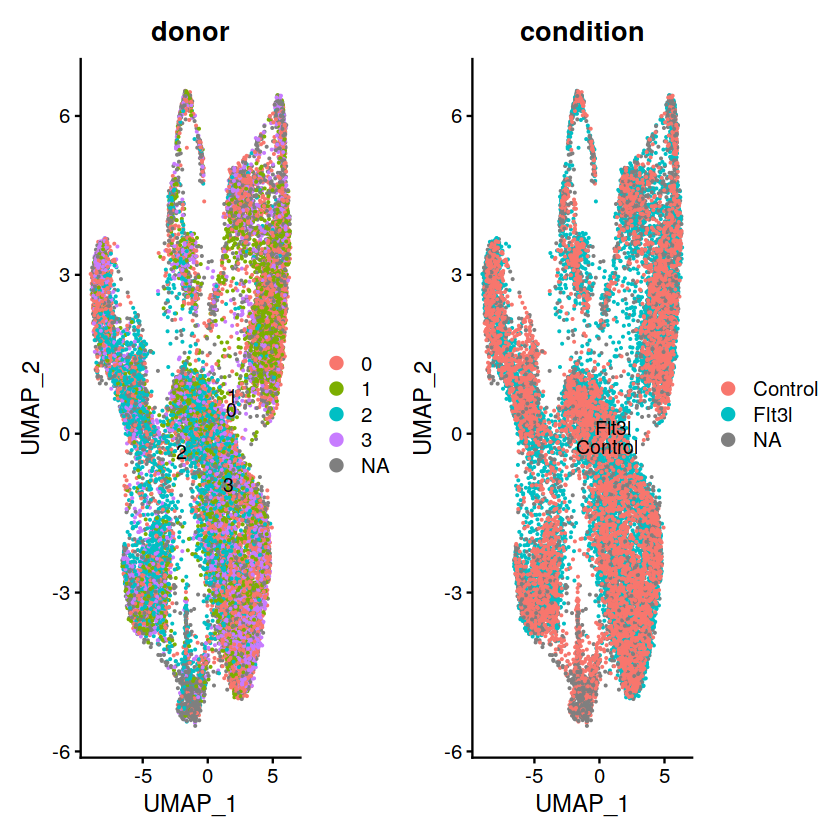

In [48]:
# Idents(t.cells) <- "orig.ident"
DimPlot(object = integrated, label = FALSE, group.by = c('donor', 'condition')) 

## Split by donor and color by condition

Saving 6.67 x 6.67 in image



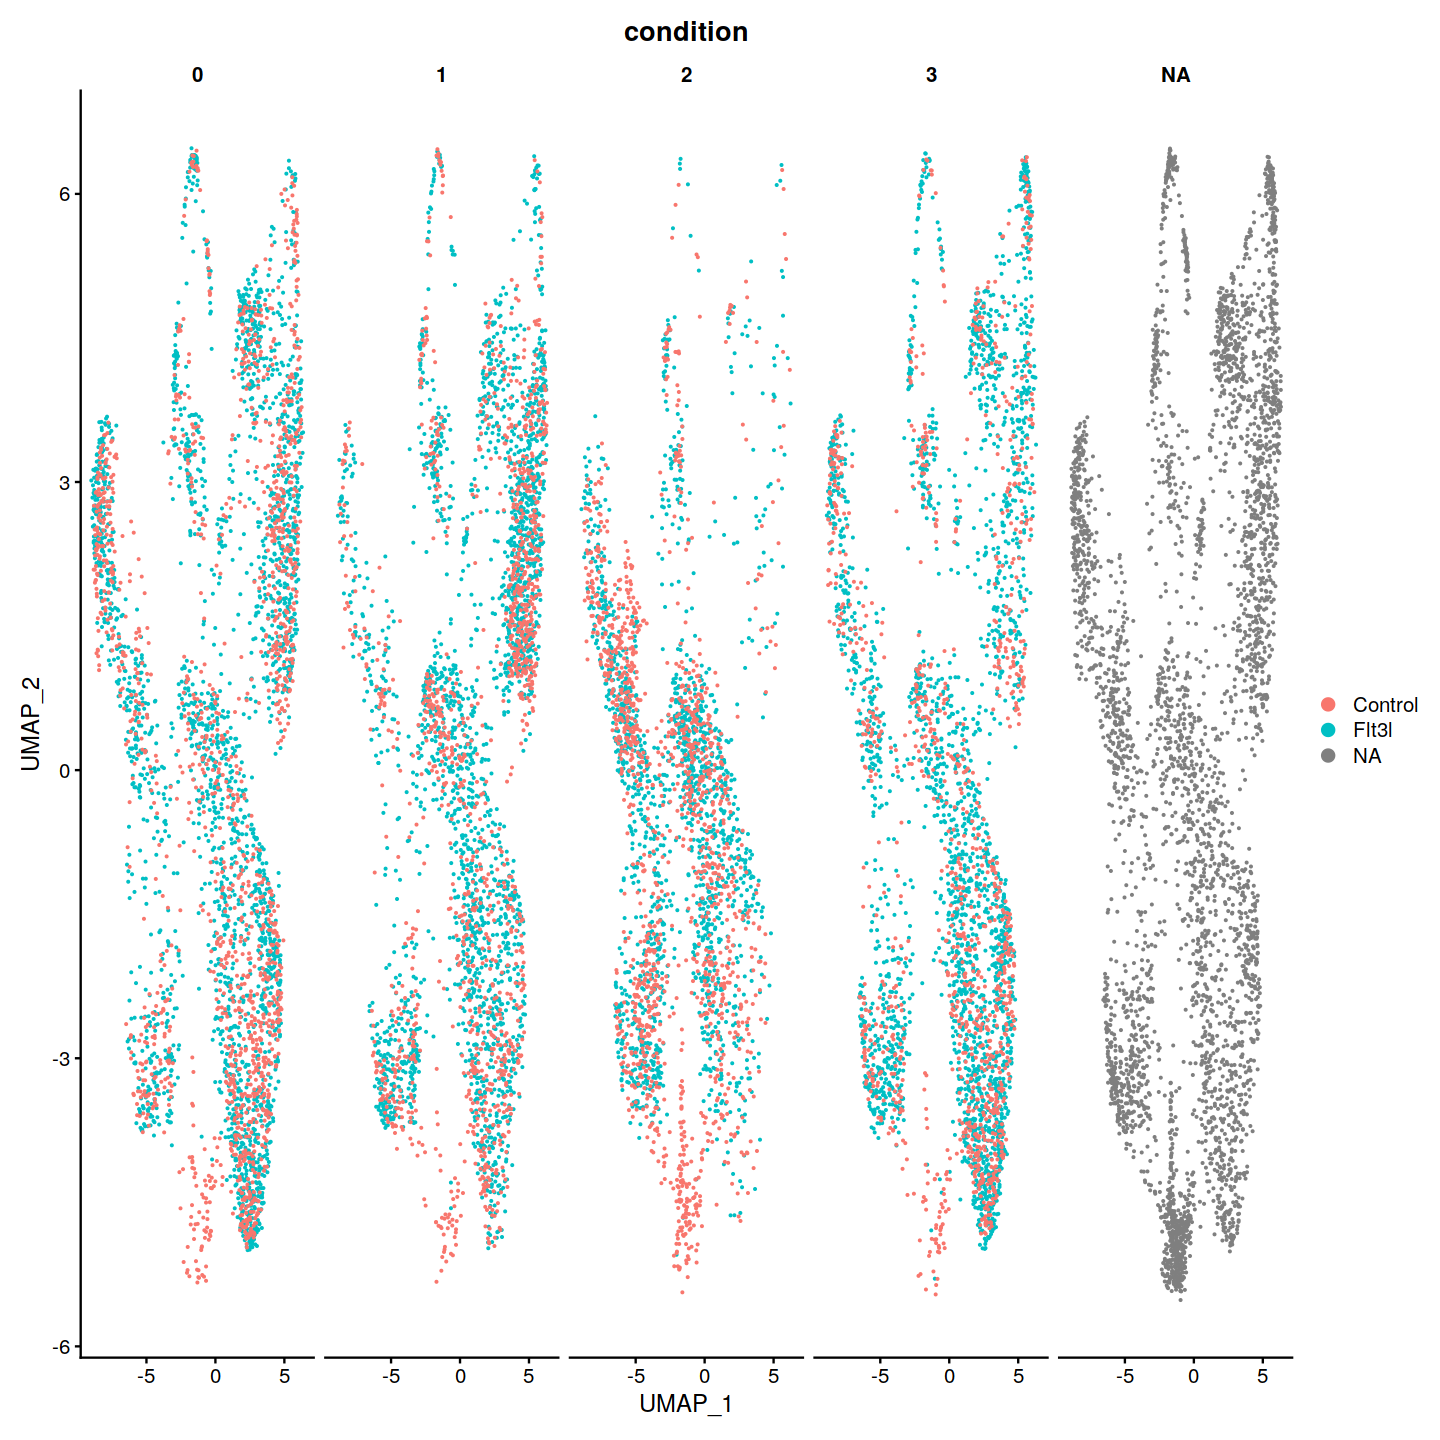

In [119]:
DimPlot(object = integrated, label = FALSE, split.by="donor", group.by = 'condition')
ggsave(file.path(outdir, "conditions.donors.png"))

## Plot lineage

Saving 6.67 x 6.67 in image



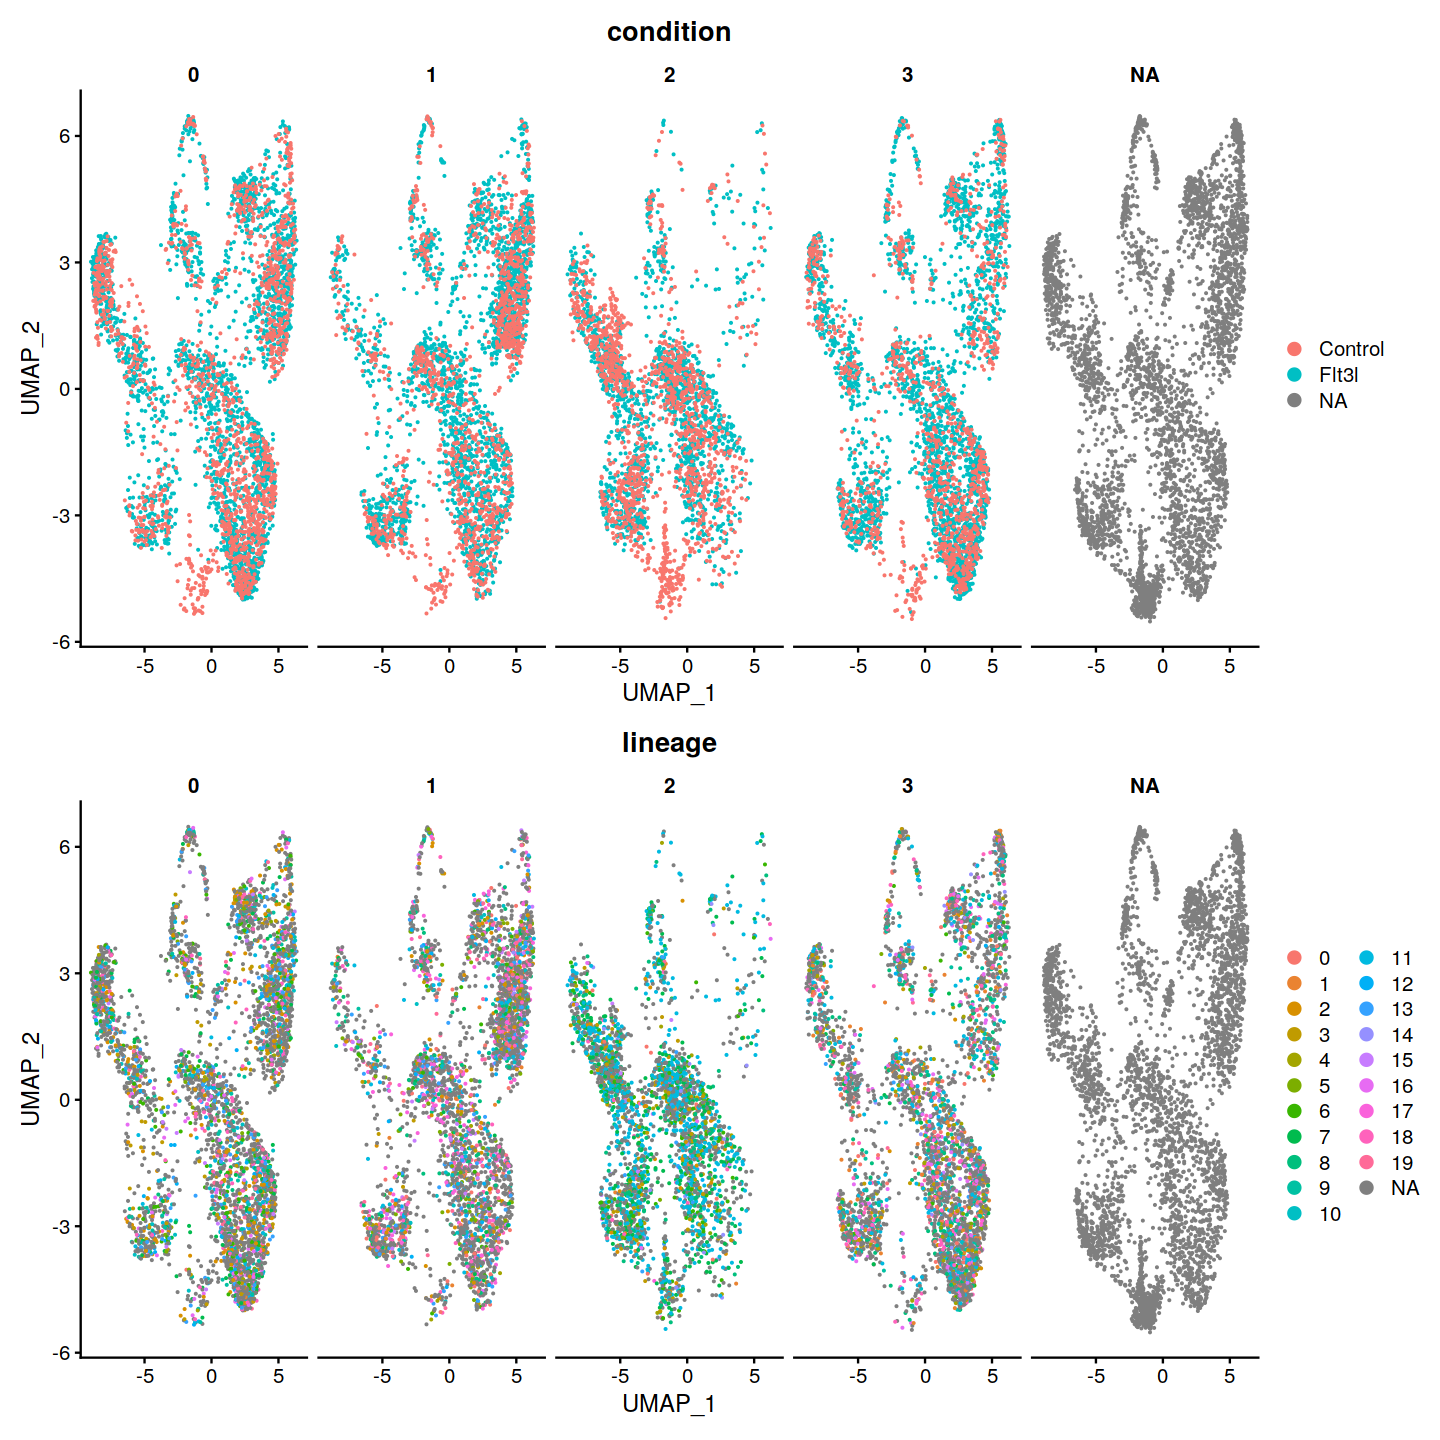

In [120]:
DimPlot(object = integrated, label = FALSE, split.by=c("donor"), group.by = c('condition', "lineage"))
ggsave(file.path(outdir, "lineage.conditions.png"))

In [ ]:
sessionInfo()